# Data preparation and cleaning
Before we work with the data and use it to train a model, we need to prepare it. This includes cleaning the data, transforming it into a format that is suitable for training a model, and splitting it into a training and test set. In this notebook, we will perform the following steps:
- Analyze the scraped dataset (class distribution)
- Use Canny edge detection to extract ROI from the images
- Crop the images to a fixed size including the ROI
- Perform data augmentation
- Construct datasets for training and testing

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

from skimage import transform
import concurrent.futures as cf
from tqdm import tqdm
import shutil

executor = cf.ThreadPoolExecutor(max_workers=4)
image_path = '../dat/images'

#### Ensure that all files are valid `jpg` and there are no errors when loading the image. Also remove any leftover certificates.

In [11]:
def resave_image(file):
    if "cert" in file or "ct" in file:
        os.remove(file)
        return 'removed ' + file
    try:
        img = Image.open(file)
        img.save(file, format='JPEG')
        return
    except:
        os.remove(file)
        return 'error with '+ file
    

for root, dirs, files in os.walk(image_path):
    print('Processing', root)
    futures = [executor.submit(resave_image, os.path.join(root, file)) for file in files if file.endswith('.jpg')]
    with tqdm(total=len(futures)) as pbar:
        for future in cf.as_completed(futures):
            pbar.update(1)
            if future.result():
                print(future.result())

Processing ../dat/gempundit_2022


0it [00:00, ?it/s]


Processing ../dat/gempundit_2022\Alexandrite


100%|██████████| 365/365 [00:00<00:00, 391.00it/s]


Processing ../dat/gempundit_2022\Alexandrite Cats Eye


100%|██████████| 125/125 [00:00<00:00, 429.23it/s]


Processing ../dat/gempundit_2022\Almandine Garnet (Pyrope)


100%|██████████| 101/101 [00:00<00:00, 400.28it/s]


Processing ../dat/gempundit_2022\Amber


100%|██████████| 141/141 [00:00<00:00, 642.62it/s]


Processing ../dat/gempundit_2022\Amethyst


100%|██████████| 2509/2509 [00:06<00:00, 400.59it/s]


Processing ../dat/gempundit_2022\Amethyst Cabochon


100%|██████████| 5/5 [00:00<00:00, 716.24it/s]


Processing ../dat/gempundit_2022\Ametrine


100%|██████████| 732/732 [00:01<00:00, 392.28it/s]


Processing ../dat/gempundit_2022\Ammolite


100%|██████████| 132/132 [00:00<00:00, 966.08it/s]


Processing ../dat/gempundit_2022\Angel Skin Coral


100%|██████████| 60/60 [00:00<00:00, 420.70it/s]


Processing ../dat/gempundit_2022\Apatite


100%|██████████| 271/271 [00:01<00:00, 241.75it/s]


Processing ../dat/gempundit_2022\Apatite Cat's Eye


100%|██████████| 716/716 [00:01<00:00, 434.05it/s]


Processing ../dat/gempundit_2022\Aquamarine


100%|██████████| 1663/1663 [00:04<00:00, 406.69it/s]


Processing ../dat/gempundit_2022\Australian Opal


100%|██████████| 3104/3104 [00:06<00:00, 451.84it/s]


Processing ../dat/gempundit_2022\Aventurine


100%|██████████| 561/561 [00:01<00:00, 403.23it/s]


Processing ../dat/gempundit_2022\Basra Pearls


100%|██████████| 266/266 [00:00<00:00, 301.37it/s]


Processing ../dat/gempundit_2022\Beryl


100%|██████████| 184/184 [00:00<00:00, 339.76it/s]


Processing ../dat/gempundit_2022\Black Onyx


 27%|██▋       | 465/1718 [00:01<00:03, 360.31it/s]


KeyboardInterrupt: 

In [12]:
gem_count = []
for gem in os.listdir(image_path):
    count = len(os.listdir(os.path.join(image_path, gem)))
    gem_count += [{'gem': gem, 'count': count}]
gem_count = pd.DataFrame(gem_count)
gem_count.sort_values(by='count', ascending=True, inplace=True)
number_of_images = gem_count['count'].sum()

c:\Users\david\miniforge3\envs\cuda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 61477 (\uf025) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


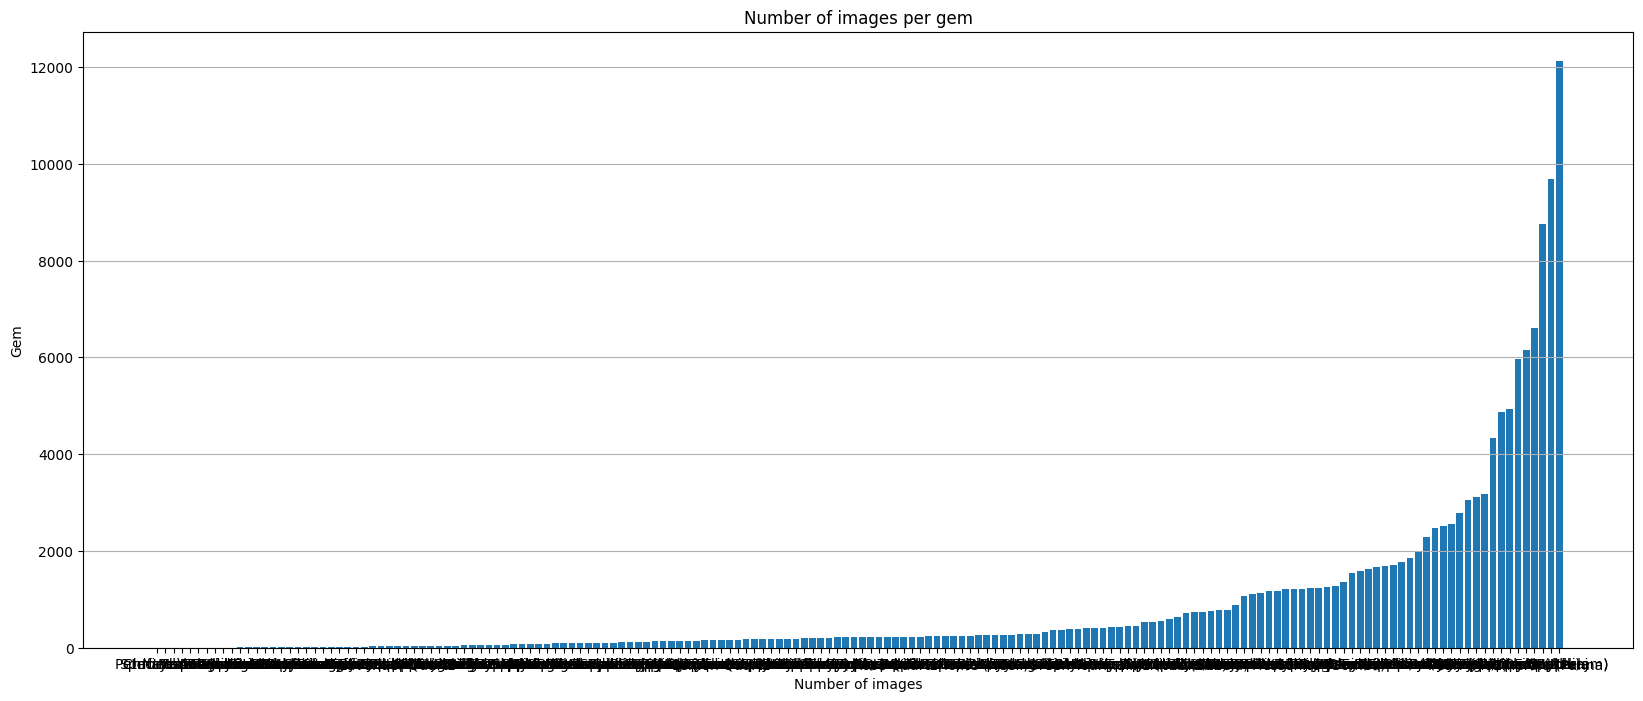

In [13]:
plt.figure(figsize=(20, 8))
plt.bar(gem_count['gem'], gem_count['count'])
plt.title('Number of images per gem')
plt.xlabel('Number of images')
plt.ylabel('Gem')
plt.grid(axis='y')
plt.show()

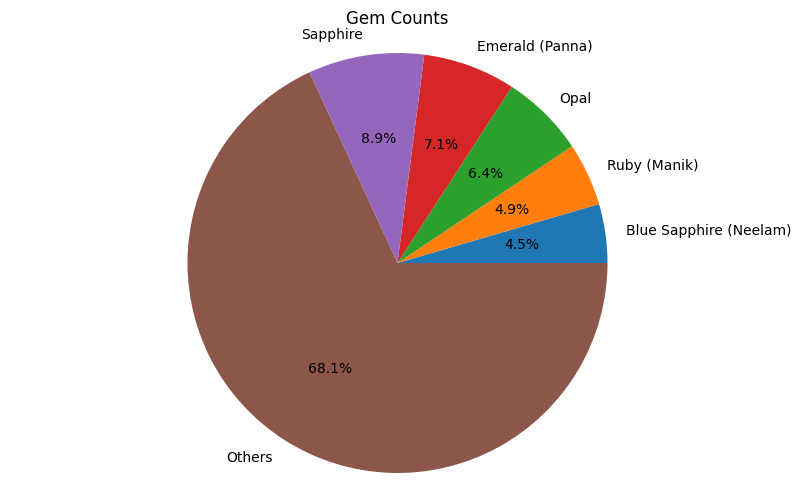

In [14]:
number_of_classes = 6

top = gem_count.tail(number_of_classes-1)
others_count = gem_count['count'].head(gem_count.shape[0] - number_of_classes).sum()
others_row = pd.DataFrame({'gem': ['Others'], 'count': [others_count]})
df = pd.concat([top, others_row], ignore_index=True)

plt.figure(figsize=(10,  6))  # Optional: set the figure size
plt.pie(df['count'], labels=df['gem'], autopct='%1.1f%%')
plt.title('Gem Counts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

We can see that the distribution of the classes is not balanced.
X classes make up for 2/3 of the total images, while the remaining 1/3 is distributed among the other X of classes.

This is a common problem in machine learning and can lead to a biased model. We will address this issue by using data augmentation to create additional training samples for the minority classes.

### Crop images using Canny edge detection

To extract the region of interest (ROI) from the images, we will use the Canny edge detection algorithm.
This ensures that the model focuses on the relevant part of the image and ignores the background.

The image is then cropped to a fixed size, including the ROI.
By doing this, we can ensure that the model receives consistent input data with maximum relevant information.

In [6]:
def edge_and_cut(img):
    try:
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #blur = cv2.GaussianBlur(gray, (2,2), 0)
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            # crop the region but let it be a square
            if (y2-y1)>(x2-x1):
                x1 = x1-(y2-y1-x2+x1)//2
                x2 = x2+(y2-y1-x2+x1)//2
            else:
                y1 = y1-(x2-x1-y2+y1)//2
                y2 = y2+(x2-x1-y2+y1)//2

            new_img = img[y1:y2, x1:x2]             

            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
            
        else:
            new_img = cv2.resize(img,(img_w, img_h))

    except Exception as e:
        return 0
    
    return new_img

In [7]:
def show_cropped(img):
    emb_img = img.copy()

    edges = cv2.Canny(emb_img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)
        # crop the region but let it be a square
        if (y2-y1)>(x2-x1):
            x1 = x1-(y2-y1-x2+x1)//2
            x2 = x2+(y2-y1-x2+x1)//2
        else:
            y1 = y1-(x2-x1-y2+y1)//2
            y2 = y2+(x2-x1-y2+y1)//2

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        #return new_img
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)
    plt.show()

In [9]:
img_w, img_h = 224, 224

img = cv2.imread('../dat/images/Alexandrite/3.jpg')
show_cropped(img)

def process_image(img, gem):
    image = cv2.imread(os.path.join(image_path, gem, img))
    image = edge_and_cut(image)
    if image is not 0:
        cv2.imwrite(os.path.join(image_path_cropped, gem, img), image)
    else:
        print(f'Error processing {img} in {gem}')


image_path_cropped = os.path.join(image_path + '_cropped')
if not os.path.exists(image_path_cropped):
    os.makedirs(image_path_cropped)

for gem in os.listdir(image_path):
    if not os.path.exists(os.path.join(image_path_cropped, gem)):
        os.makedirs(os.path.join(image_path_cropped, gem))
    futures = [executor.submit(process_image, img, gem) for img in os.listdir(os.path.join(image_path, gem))]
    print(f'Processing {gem}...')
    with tqdm(total=len(futures)) as pbar:
        for future in cf.as_completed(futures):
            future.result()
            pbar.update()

<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\david\AppData\Local\Temp\ipykernel_1708\3228108315.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if image is not 0:


Processing Alexandrite...


  0%|          | 0/366 [00:00<?, ?it/s]

100%|██████████| 366/366 [00:01<00:00, 187.68it/s]


Processing Alexandrite Cats Eye...


100%|██████████| 125/125 [00:00<00:00, 135.38it/s]


Processing Almandine Garnet (Pyrope)...


100%|██████████| 101/101 [00:00<00:00, 117.76it/s]


Processing Amber...


100%|██████████| 141/141 [00:00<00:00, 230.96it/s]


Processing Amethyst...


100%|██████████| 2510/2510 [00:16<00:00, 151.97it/s]


Processing Amethyst Cabochon...


100%|██████████| 5/5 [00:00<00:00, 278.50it/s]


Processing Ametrine...


100%|██████████| 732/732 [00:04<00:00, 147.01it/s]


Processing Ammolite...


100%|██████████| 132/132 [00:00<00:00, 265.22it/s]


Processing Angel Skin Coral...


100%|██████████| 60/60 [00:00<00:00, 128.82it/s]


Processing Apatite...


100%|██████████| 271/271 [00:02<00:00, 134.79it/s]


Processing Apatite Cat's Eye...


100%|██████████| 716/716 [00:04<00:00, 148.25it/s]


Processing Aquamarine...


100%|██████████| 1663/1663 [00:12<00:00, 134.17it/s]


Processing Australian Opal...


100%|██████████| 3104/3104 [00:18<00:00, 165.84it/s]


Processing Aventurine...


100%|██████████| 561/561 [00:03<00:00, 173.76it/s]


Processing Basra Pearls...


100%|██████████| 266/266 [00:01<00:00, 156.62it/s]


Processing Beryl...


100%|██████████| 184/184 [00:01<00:00, 154.17it/s]


Processing Black Onyx...


100%|██████████| 1718/1718 [00:10<00:00, 161.34it/s]


Processing Black Opal...


100%|██████████| 1213/1213 [00:08<00:00, 141.85it/s]


Processing Black Pearls...


100%|██████████| 240/240 [00:01<00:00, 158.99it/s]


Processing Black Spinel...


100%|██████████| 316/316 [00:02<00:00, 151.60it/s]


Processing Black Tourmaline...


100%|██████████| 40/40 [00:00<00:00, 141.72it/s]


Processing Blizzard Stone...


100%|██████████| 6/6 [00:00<00:00, 273.45it/s]


Processing Bloodstone...


100%|██████████| 767/767 [00:10<00:00, 74.81it/s] 


Processing Blue Moonstone...


100%|██████████| 70/70 [00:00<00:00, 80.04it/s] 


Processing Blue Opal...


100%|██████████| 217/217 [00:01<00:00, 167.16it/s]


Processing Blue Sapphire (Neelam)...


100%|██████████| 6149/6149 [00:44<00:00, 138.37it/s]


Processing Blue Spinel...


100%|██████████| 21/21 [00:00<00:00, 277.06it/s]


Processing Blue Topaz...


100%|██████████| 1173/1173 [00:07<00:00, 148.95it/s]


Processing Blue Zircon...


100%|██████████| 246/246 [00:01<00:00, 157.94it/s]


Processing Brazilian Emerald...


100%|██████████| 1271/1271 [00:08<00:00, 145.00it/s]


Processing Brown Moonstone...


100%|██████████| 370/370 [00:02<00:00, 139.33it/s]


Processing Brown Zircon...


100%|██████████| 241/241 [00:00<00:00, 264.52it/s]


Processing Burmese Ruby...


100%|██████████| 1121/1121 [00:08<00:00, 134.73it/s]


Processing Burmese Sapphire...


100%|██████████| 109/109 [00:00<00:00, 149.94it/s]


Processing Carnelian...


100%|██████████| 260/260 [00:01<00:00, 136.19it/s]


Processing Cats Eye...


100%|██████████| 2555/2555 [00:17<00:00, 148.33it/s]


Processing Cats Eye Moonstone...


100%|██████████| 133/133 [00:00<00:00, 163.61it/s]


Processing Cats Eye Opal...


100%|██████████| 54/54 [00:00<00:00, 151.95it/s]


Processing Cats Eye Quartz...


100%|██████████| 214/214 [00:01<00:00, 135.47it/s]


Processing Chrome Tourmaline...


100%|██████████| 2/2 [00:00<00:00, 334.25it/s]


Processing Chrysoberyl...


100%|██████████| 15/15 [00:00<00:00, 107.43it/s]


Processing Chrysoberyl Cats Eye (Lehsunia)...


100%|██████████| 1262/1262 [00:00<00:00, 10371.85it/s]


Processing Chrysocolla...


100%|██████████| 275/275 [00:01<00:00, 139.29it/s]


Processing Citrine (Sunela)...


100%|██████████| 730/730 [00:05<00:00, 137.54it/s]


Processing Colombian Emerald...


100%|██████████| 1217/1217 [00:09<00:00, 132.99it/s]


Processing Color Change Sapphire...


100%|██████████| 47/47 [00:00<00:00, 108.75it/s]


Processing Cornflower Blue Sapphire...


100%|██████████| 23/23 [00:00<00:00, 113.05it/s]


Processing Cultured Pearls...


100%|██████████| 2467/2467 [00:16<00:00, 147.33it/s]


Processing CVN15J~1...


100%|██████████| 2783/2783 [00:20<00:00, 132.88it/s]


Processing Danburite...


100%|██████████| 4/4 [00:00<00:00, 114.59it/s]


Processing Emerald (Panna)...


100%|██████████| 9686/9686 [01:05<00:00, 147.24it/s]


Processing Ethiopian Emerald...


100%|██████████| 213/213 [00:02<00:00, 102.41it/s]


Processing Ethiopian Opal...


100%|██████████| 3170/3170 [00:20<00:00, 157.69it/s]


Processing Fire Opal...


100%|██████████| 396/396 [00:02<00:00, 152.37it/s]


Processing Fluorite...


100%|██████████| 163/163 [00:01<00:00, 158.13it/s]


Processing Garnet...


100%|██████████| 780/780 [00:05<00:00, 154.17it/s]


Processing Glass Filled Ruby...


100%|██████████| 1684/1684 [00:11<00:00, 151.21it/s]


Processing Golden Topaz...


100%|██████████| 215/215 [00:01<00:00, 146.50it/s]


Processing Goshenite...


100%|██████████| 98/98 [00:00<00:00, 146.22it/s]


Processing Grandidierite...


100%|██████████| 102/102 [00:00<00:00, 137.46it/s]


Processing Green Amethyst (Prasiolite)...


100%|██████████| 418/418 [00:02<00:00, 158.05it/s]


Processing Green Kyanite...


100%|██████████| 210/210 [00:01<00:00, 145.49it/s]


Processing Green Sapphire...


100%|██████████| 55/55 [00:00<00:00, 113.39it/s]


Processing Green Tanzanite...


100%|██████████| 21/21 [00:00<00:00, 126.08it/s]


Processing Green Tourmaline (Verdelite)...


100%|██████████| 450/450 [00:02<00:00, 152.07it/s]


Processing Grey Sapphire...


100%|██████████| 27/27 [00:00<00:00, 132.71it/s]


Processing Heliodor...


100%|██████████| 188/188 [00:01<00:00, 159.22it/s]


Processing Hessonite (Gomed)...


100%|██████████| 1230/1230 [00:07<00:00, 169.11it/s]


Processing Imperial Topaz...


100%|██████████| 224/224 [00:01<00:00, 144.52it/s]


Processing Indian Emerald...


100%|██████████| 24/24 [00:00<00:00, 129.38it/s]


Processing Indian Ruby...


100%|██████████| 243/243 [00:01<00:00, 151.42it/s]


Processing Insignificant Oil Emerald...


100%|██████████| 29/29 [00:00<00:00, 136.51it/s]


Processing Iolite (Neeli)...


100%|██████████| 260/260 [00:01<00:00, 197.50it/s]


Processing Iranian Turquoise (Irani Feroza)...


100%|██████████| 215/215 [00:00<00:00, 220.29it/s]


Processing Jade...


100%|██████████| 537/537 [00:03<00:00, 167.99it/s]


Processing Jade Nephrite...


100%|██████████| 143/143 [00:00<00:00, 187.92it/s]


Processing Jadeite...


100%|██████████| 409/409 [00:02<00:00, 164.02it/s]


Processing Japanese Red Coral...


100%|██████████| 171/171 [00:01<00:00, 122.74it/s]


Processing Jasper...


100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


Processing Kashmir Blue Sapphire...


100%|██████████| 91/91 [00:00<00:00, 137.51it/s]


Processing Keshi Pearls...


100%|██████████| 450/450 [00:02<00:00, 151.44it/s]


Processing Khooni Neelam...


100%|██████████| 42/42 [00:00<00:00, 117.63it/s]


Processing Kunzite...


100%|██████████| 222/222 [00:01<00:00, 144.39it/s]


Processing Kyanite...


100%|██████████| 1367/1367 [00:06<00:00, 216.73it/s]


Processing Lapis Lazuli...


100%|██████████| 179/179 [00:01<00:00, 143.11it/s]


Processing Lavender Quartz...


100%|██████████| 33/33 [00:00<00:00, 115.29it/s]


Processing Lemon Quartz...


100%|██████████| 162/162 [00:01<00:00, 152.19it/s]


Processing LLHKW1~S...


100%|██████████| 41/41 [00:00<00:00, 114.19it/s]


Processing London Blue Topaz...


100%|██████████| 198/198 [00:01<00:00, 148.93it/s]


Processing Malachite...


100%|██████████| 4/4 [00:00<00:00, 308.52it/s]


Processing Mandarin Garnet...


100%|██████████| 18/18 [00:00<00:00, 135.70it/s]


Processing Mexican Fire Opal...


100%|██████████| 420/420 [00:02<00:00, 154.26it/s]


Processing Mocha Scapolite...


100%|██████████| 27/27 [00:00<00:00, 136.73it/s]


Processing Moldavite...


100%|██████████| 1851/1851 [00:12<00:00, 150.80it/s]


Processing Moonstone...


100%|██████████| 1576/1576 [00:10<00:00, 147.16it/s]


Processing Morganite...


100%|██████████| 293/293 [00:01<00:00, 173.17it/s]


Processing Moss Agate...


100%|██████████| 3/3 [00:00<00:00, 200.53it/s]


Processing Mozambique Ruby...


100%|██████████| 1165/1165 [00:07<00:00, 148.87it/s]


Processing Natural Pearls...


100%|██████████| 289/289 [00:01<00:00, 152.92it/s]


Processing Navratna...


100%|██████████| 1/1 [00:00<00:00, 200.59it/s]


Processing Neon Apatite...


100%|██████████| 194/194 [00:01<00:00, 144.93it/s]


Processing Obsidian...


100%|██████████| 148/148 [00:01<00:00, 145.34it/s]


Processing Onyx (Chalcedony)...


100%|██████████| 4342/4342 [00:29<00:00, 147.23it/s]


Processing Opal...


100%|██████████| 8751/8751 [00:54<00:00, 160.95it/s]


Processing Orange Kyanite...


100%|██████████| 24/24 [00:00<00:00, 130.78it/s]


Processing Orange Sapphire...


100%|██████████| 6/6 [00:00<00:00, 250.66it/s]


Processing Padparadscha Sapphire...


100%|██████████| 99/99 [00:00<00:00, 123.93it/s]


Processing Panjshir Emerald...


100%|██████████| 46/46 [00:00<00:00, 140.97it/s]


Processing Paraiba Tourmaline...


100%|██████████| 175/175 [00:01<00:00, 141.48it/s]


Processing Peach Morganite...


100%|██████████| 39/39 [00:00<00:00, 258.97it/s]


Processing Peacock Tanzanite...


100%|██████████| 15/15 [00:00<00:00, 113.08it/s]


Processing Pearl (Moti)...


100%|██████████| 3053/3053 [00:18<00:00, 161.47it/s]


Processing Peridot...


100%|██████████| 602/602 [00:03<00:00, 153.31it/s]


Processing Petrified Wood...


100%|██████████| 1/1 [00:00<00:00, 167.11it/s]


Processing Pigeon Blood Ruby...


100%|██████████| 157/157 [00:01<00:00, 143.59it/s]


Processing Pink Coral...


100%|██████████| 87/87 [00:00<00:00, 145.87it/s]


Processing Pink Morganite...


100%|██████████| 86/86 [00:00<00:00, 183.08it/s]


Processing Pink Opal...


100%|██████████| 50/50 [00:00<00:00, 165.76it/s]


Processing Pink Sapphire...


100%|██████████| 411/411 [00:02<00:00, 155.33it/s]


Processing Pink Spinel...


100%|██████████| 135/135 [00:00<00:00, 160.00it/s]


Processing Pink Topaz...


100%|██████████| 126/126 [00:00<00:00, 147.76it/s]


Processing Pink Tourmaline...


100%|██████████| 273/273 [00:01<00:00, 159.88it/s]


Processing Pitambari Neelam...


100%|██████████| 1118/1118 [00:07<00:00, 155.97it/s]


Processing Purple Garnet...


100%|██████████| 216/216 [00:01<00:00, 146.82it/s]


Processing Purple Sapphire...


100%|██████████| 168/168 [00:01<00:00, 146.28it/s]


Processing Rainbow Moonstone...


100%|██████████| 68/68 [00:00<00:00, 152.25it/s]


Processing Red Coral (Moonga)...


100%|██████████| 2290/2290 [00:14<00:00, 161.60it/s]


Processing Red Spinel...


100%|██████████| 35/35 [00:00<00:00, 142.66it/s]


Processing Red Tourmaline...


100%|██████████| 8/8 [00:00<00:00, 74.97it/s]


Processing Rose Quartz...


100%|██████████| 217/217 [00:01<00:00, 160.93it/s]


Processing Royal Blue Sapphire...


100%|██████████| 96/96 [00:00<00:00, 143.81it/s]


Processing Rubellite...


100%|██████████| 175/175 [00:01<00:00, 162.05it/s]


Processing Ruby (Manik)...


100%|██████████| 6609/6609 [00:43<00:00, 151.50it/s]


Processing Russian Emerald...


100%|██████████| 39/39 [00:00<00:00, 128.21it/s]


Processing Sapphire...


100%|██████████| 12122/12122 [01:17<00:00, 155.88it/s]


Processing Sky Blue Topaz...


100%|██████████| 774/774 [00:05<00:00, 150.49it/s]


Processing Smoky Quartz...


100%|██████████| 212/212 [00:01<00:00, 140.17it/s]


Processing South Sea Pearls...


100%|██████████| 2005/2005 [00:12<00:00, 157.11it/s]


Processing Spectrolite...


0it [00:00, ?it/s]


Processing Spessartite...


100%|██████████| 81/81 [00:00<00:00, 138.03it/s]


Processing Spinel...


100%|██████████| 535/535 [00:03<00:00, 159.16it/s]


Processing Sri Lanka Moonstone...


100%|██████████| 7/7 [00:00<00:00, 233.96it/s]


Processing Star Garnet...


100%|██████████| 12/12 [00:00<00:00, 112.45it/s]


Processing Star Ruby...


100%|██████████| 1211/1211 [00:08<00:00, 148.47it/s]


Processing Star Sapphire...


100%|██████████| 184/184 [00:01<00:00, 149.34it/s]


Processing Sunstone...


100%|██████████| 95/95 [00:00<00:00, 148.83it/s]


Processing Swiss Blue Topaz...


100%|██████████| 401/401 [00:02<00:00, 160.74it/s]


Processing Tahitian Pearls...


100%|██████████| 240/240 [00:02<00:00, 104.69it/s]


Processing Tanzania Ruby...


100%|██████████| 5/5 [00:00<00:00, 147.45it/s]


Processing Tanzanite...


100%|██████████| 392/392 [00:02<00:00, 170.91it/s]


Processing Teal Sapphire...


100%|██████████| 3/3 [00:00<00:00, 143.24it/s]


Processing Tiger Eye...


100%|██████████| 96/96 [00:00<00:00, 137.75it/s]


Processing Titanite...


100%|██████████| 4/4 [00:00<00:00, 129.38it/s]


Processing Topaz...


100%|██████████| 1776/1776 [00:11<00:00, 158.50it/s]


Processing Tourmaline...


100%|██████████| 1079/1079 [00:07<00:00, 151.01it/s]


Processing Tsavorite...


100%|██████████| 157/157 [00:01<00:00, 147.41it/s]


Processing TUNFRO~K...


100%|██████████| 882/882 [00:04<00:00, 183.23it/s]


Processing Turquoise (Firoza)...


100%|██████████| 1534/1534 [00:08<00:00, 184.55it/s]


Processing Vivid Green Emerald...


100%|██████████| 20/20 [00:00<00:00, 107.67it/s]


Processing White Coral...


100%|██████████| 228/228 [00:01<00:00, 160.52it/s]


Processing White Opal...


100%|██████████| 5971/5971 [00:36<00:00, 162.58it/s]


Processing White Sapphire...


100%|██████████| 1626/1626 [00:09<00:00, 166.97it/s]


Processing White Topaz...


100%|██████████| 109/109 [00:00<00:00, 146.82it/s]


Processing White Zircon...


100%|██████████| 635/635 [00:03<00:00, 174.62it/s]


Processing Yellow Beryl...


100%|██████████| 206/206 [00:01<00:00, 153.36it/s]


Processing Yellow Sapphire - Pukhraj...


100%|██████████| 4875/4875 [00:32<00:00, 150.93it/s]


Processing Yellow Topaz...


100%|██████████| 240/240 [00:01<00:00, 147.77it/s]


Processing Yellow Zircon...


100%|██████████| 45/45 [00:00<00:00, 135.50it/s]


Processing Zambian Emerald...


100%|██████████| 4924/4924 [00:32<00:00, 151.55it/s]


Processing Zircon...


100%|██████████| 1225/1225 [00:06<00:00, 179.24it/s]


### Perform image augmentation

In [2]:
def transform_images(src, dst, goal, rotations):
    for root, dirs, _ in os.walk(src):
        for dir in dirs:
            files = os.listdir(os.path.join(root, dir))

            flip = False
            size = len(files)
            num_to_edit = np.ceil((goal-size) / 3).astype(int)

            if not os.path.exists(os.path.join(dst, dir)):
                os.makedirs(os.path.join(dst, dir))

            for file in np.random.choice(files, min(size, goal), replace=False):
                shutil.copy(os.path.join(root, dir, file), os.path.join(dst, dir, file))

            if num_to_edit > size:
                flip = True
                num_to_edit = np.ceil((goal-size) / 7).astype(int)
            print(dir, max(0, min(num_to_edit, size)))


            for file in np.random.choice(files, max(0, min(num_to_edit, size)), replace=False):
                try:
                    image = cv2.imread(os.path.join(root, dir, file))
                    if flip:
                        plt.imsave(os.path.join(dst, dir, file[:-4]+'_flip'+file[-4:]), np.fliplr(image))
                        plt.imsave(os.path.join(dst, dir, file[:-4]+'_flip'+file[-4:]), np.flipud(image))
                    # apply different rotations
                    for angle in rotations:
                        # save image
                        rot_img = transform.rotate(image, angle=angle)
                        plt.imsave(os.path.join(dst, dir, file[:-4]+'_rot'+str(angle)+file[-4:]), rot_img)
                        if flip:
                            plt.imsave(os.path.join(dst, dir, file[:-4]+'_'+str(angle)+'_fliplr'+file[-4:]), np.fliplr(rot_img))
                            plt.imsave(os.path.join(dst, dir, file[:-4]+'_'+str(angle)+'_flipud'+file[-4:]), np.flipud(rot_img))
                except:
                    pass

In [5]:
rotations = [90, 180, 270]
goal = [1000, 2000]

image_path_cropped = '../dat/images_cropped'
image_path_cropped_augmented = []

for g in goal:
    upper_bound = goal * 1.1
    lower_bound = goal * 0.9

    dst = image_path_cropped + '_augmented_' + str(g)
    image_path_cropped_augmented.append(dst)
    if not os.path.exists(image_path_cropped_augmented):
        os.makedirs(image_path_cropped_augmented)
    transform_images(src=image_path_cropped, dst=image_path_cropped_augmented[-1], goal=g, rotations=rotations)

    for root, dirs, files in os.walk(image_path_cropped_augmented):
        if root != image_path_cropped_augmented:
            if len(files) < lower_bound:
                shutil.rmtree(root)
            elif len(files) > upper_bound:
                for file in np.random.choice(files, int(len(files)-upper_bound), replace=False):
                    os.remove(os.path.join(root, file))

Alexandrite 213
Alexandrite Cats Eye 125
Almandine Garnet (Pyrope) 101
Amber 123
Amethyst 0
Amethyst Cabochon 5
Ametrine 90
Ammolite 124
Angel Skin Coral 60
Apatite 243
Apatite Cat's Eye 95
Aquamarine 0
Australian Opal 0
Aventurine 147
Basra Pearls 245
Beryl 117
Black Onyx 0
Black Opal 0
Black Pearls 109
Black Spinel 228
Black Tourmaline 40
Blizzard Stone 6
Bloodstone 78
Blue Moonstone 70
Blue Opal 112
Blue Sapphire (Neelam) 0
Blue Spinel 21
Blue Topaz 0
Blue Zircon 108
Brazilian Emerald 0
Brown Moonstone 210
Brown Zircon 109
Burmese Ruby 0
Burmese Sapphire 109
Carnelian 247
Cats Eye 0
Cats Eye Moonstone 124
Cats Eye Opal 54
Cats Eye Quartz 113
Chrome Tourmaline 2
Chrysoberyl 15
Chrysoberyl Cats Eye (Lehsunia) 0
Chrysocolla 242
Citrine (Sunela) 90
Colombian Emerald 0
Color Change Sapphire 47
Cornflower Blue Sapphire 23
Cultured Pearls 0
CVN15J~1 0
Danburite 4
Emerald (Panna) 0
Ethiopian Emerald 113
Ethiopian Opal 0
Fire Opal 202
Fluorite 120
Garnet 74
Glass Filled Ruby 0
Golden Topaz 